# L4 - Обучение с подкреплением (reinforcement learning)

**Обучение с подкреплением** - один из способов машинного обучения, где некоторый агент обучается, взаимодействуя со средой. В отличие от обучения с учителем тут нет размеченных данных. Однако агент обладает набором допустимых действий, выполняя которые, он получает награду. Цель агента - максимизировать суммарную награду за какой-то период времени. Рассмотрим возможные постановки задачи.

Материал этой лабораторной основывается на этой прекрасной [книге](https://webdocs.cs.ualberta.ca/~sutton/book/bookdraft2016sep.pdf), которой вы можете впоспользоваться.

## 1. Задача о многоруком бандите (multi-armed bandit problem)

### Постановка задачи

#### Неформальная
Пусть есть $N$ игровых автоматов. Сыграв на $i$-м автомате, агент получает награду, которая задается случайной величиной. Агент не знает, как устроены распределения, однако перед ним стоит задача максимизировать выигрыш, сыграв $T$ раз.

#### Формальная
Пусть есть конечное множество возможных действий $\mathcal{A}$. Для каждого действия $a \in \mathcal{A}$ существует премия, которая определяется неизвестным распределением $p(r|a)$. Стратегия агента (policy) в момент $t$ - это некоторое вероятностное распределение на множестве всех действий $\pi_t(a)$.

Игра происходит следующим образом:
> 1. У агента есть некоторая начальная стратегия $\pi_1(a)$
> 2. В каждый момент времени $1 \leq t \leq T$:
> 3. Выбирает действией $a_t \sim \pi_t(a)$
> 4. Получает свою награду $r_t \sim p(r|a_t)$
> 5. Корректирует свою стратегию $\pi_t \rightarrow \pi_{t+1}$

Пусть $c_t(a)$ - количество раз, которое агент выбрал действие $a$ к моменту $t$
$$c_t(a) = \sum_{i=1}^{t}[A_i = a]$$
Тогда задачей агента является минимизация сожаления к моменту $T$, а именно
$$T\cdot\mu^* - \sum_a \mu_a \mathbb{E}[c_T(a)]$$
* $\mu_a$ - мат. ожидание награды за действие $a$
* $\mu^* = \max_a \mu_a$ - мат. ожидание оптимального действия

Также можно встретить следующее определение сожаления:
$$T\cdot\mu^* - \mathbb{E}\big[ \sum_{t=1}^{T} R_t \big].$$

Впервые задача была предложена в этой [статье](http://projecteuclid.org/download/pdf_1/euclid.bams/1183517370).
### Модельная задача
1. $|A| = 100, T = 1000$
2. $\mu_a \sim \mathcal{N}(0, 1)$
3. $p(r|a) = \mathcal{N}(r; \mu_a, 1)$

Симуляция игры запускается $10^4$ раз, и строится график в осях **[номер шага в игре]** $\times$ **[усредненная суммарная премия к текущему шагу]**.

In [1]:
import numpy as np
class Model:
    """ Creates basic Model environment:
    Actions: |A|.
    Exp_action_val: Expected value of distribution in actions.
    Reward_exp: Probability to get a reward.
    """
    def __init__(self, actions, exp_action_val):
        self.actions = actions
        self.exp_action_val = exp_action_val
    def get_reward():
        pass
    
    
class Agent:
    """ Agent implementation which maps every possible percepts sequence
    to a possible action the agent can perform or to a coefficient, feedback element,
    function or constant that affects eventual actions: f:P→A
    """
    def __init__(self, Model):
        self.model = Model
        self.q_function = np.zeros((self.model.actions))
    
    def get_reward(self, action):
        return self.model.get_reward(action)
    
    def choose_action(self):
        pass
    
    def correct_strategy(self):
        pass
    
    def update_Q(self, time, cur_reward, action):
        self.q_function = self.q_function * (time - 1)
        self.q_function[action] += cur_reward
        self.q_function /= time
    
    def step(self, time):
        action = self.choose_action()
        cur_reward = self.get_reward(action)
        self.update_Q(time, cur_reward, action)
        self.correct_strategy()
        return cur_reward

In [2]:
class GreedyAgent(Agent):
    """ Implementation of Greedy Policy agent"""
    def __init__(self, Model):
        self.model = Model
        self.q_function = np.zeros((self.model.actions))
        self.argmax_actions_pool = np.random.uniform(size=(self.model.actions))

    def choose_action(self):
        return np.random.randint(0, len(self.argmax_actions_pool))
            
class BasicModel(Model):
    def get_reward(self, action):
        return np.random.normal(self.exp_action_val, 1)
        

### Известные стратегии
Введем следущие определения:
* $Q_t(a)$ - средняя премия действия $a$ к раунду $t$ (value of action), при росте $c_t(a)$ стремится к $\mu_a$.
* $Q^*(a) = \lim_{t \rightarrow \infty} Q_t(a)$ - ценность действия $a$.
* $\mathcal{A}_t = \arg\max_a Q_t(a)$ - множество действий, которое имеет максимальную среднюю премию к раунду $t$.

**Задание**
1. Можно ли вычислить $Q_{t+1}(a)$ инкрементально (известно лишь  $Q_t(a)$ и награда  $r_{t+1}$, назначенная за выбор действия $a$)?
2. Используйте этот подход далее.

#### Жадная стратегия (greedy policy)
Стратегия $\pi_t$ заключается в том, что мы равновероятно выбираем $a$ из $\mathcal{A}_t$
$$\pi_t(a)= \frac{1}{|\mathcal{A}_t|}[a \in \mathcal{A}_t]$$
**Задание**
1. Реализуйте данную стратегию
2. Опишите ее главный недостаток
3. Как вы инициализировали $\pi_1$?
4. Нужно ли несколько стартовых игр, чтобы инициализировать $\pi_1$?

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

T = 1000
n_steps = 10000

reward_mean_data = np.zeros(T)

for n_step in tqdm(range(n_steps)):
    base_model = BasicModel(100, np.random.normal(0,1))
    greedy_agent = GreedyAgent(base_model)
    
    temp_reward_one_game = np.zeros(T)
    cur_reward = 0
    
    for time in range(1, T):
        temp_reward_one_game[time] = cur_reward
        reward = greedy_agent.step(time)
        cur_reward += reward
    reward_mean_data += temp_reward_one_game

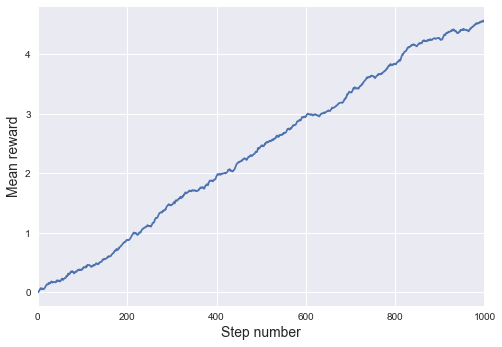

In [68]:
import seaborn as sns
plt.xlabel('Step number', fontsize = 14)
plt.ylabel('Mean reward', fontsize = 14)
sns.tsplot(reward_mean_data / n_steps, [i for i in range(T)])

#### $\varepsilon$-жадная стратегия ($\varepsilon$-greedy policy)
Проблема предыдущего подхода в том, что он лишь жадным образом пытается эксплуатировать среду. Однако какое-то время необходимо тратить также на ее изучение, чтобы максимизировать премию в долгосрочном периоде. Таким образом идет речь о балансе *exploration/exploitation*.

Возможная модификация предыдущего подхода:
$$\pi_t(a)=\frac{1-\varepsilon}{|\mathcal{A}_t|}[a \in A_t] + \frac{\varepsilon}{|\mathcal{A}|},\ \varepsilon \in [0, 1]$$



**Задание**
1. Реализуйте данную стратегию
2. Что происходит с ростом $\varepsilon$?
3. Как бы изменяли $\varepsilon$ по мере обучения агента?
4. Опробуйте жадную и $\varepsilon$-жадную стратегии на модельной задаче. Попробуйте разные $\varepsilon$.

In [18]:
class EpsGreedyAgent(Agent):
    """ Implementation of Epsilon Greedy Policy agent"""
    def __init__(self, Model, epsilon):
        self.model = Model
        self.q_function = np.zeros((self.model.actions))
        self.argmax_actions_pool = np.random.uniform(size=(self.model.actions))
        self.epsilon = epsilon

    def choose_action(self):
        return int((1-self.epsilon) * np.random.randint(0, len(self.argmax_actions_pool)) +
                   self.epsilon * np.random.randint(0, self.model.actions))

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

T = 100
n_steps = 10

greedy_policy_data = []
for epsilon in range(0, 10):
    reward_mean_data = np.zeros(T)
    for n_step in tqdm(range(n_steps)):
        base_model = BasicModel(100, np.random.normal(0,1))
        eps_greedy_agent = EpsGreedyAgent(base_model, epsilon * 0.1)

        temp_reward_one_game = np.zeros(T)
        cur_reward = 0

        for time in range(1, T):
            temp_reward_one_game[time] = cur_reward
            reward = eps_greedy_agent.step(time)
            cur_reward += reward
        reward_mean_data += temp_reward_one_game
    greedy_policy_data.append(reward_mean_data)

100%|██████████| 10/10 [00:00<00:00, 281.22it/s]


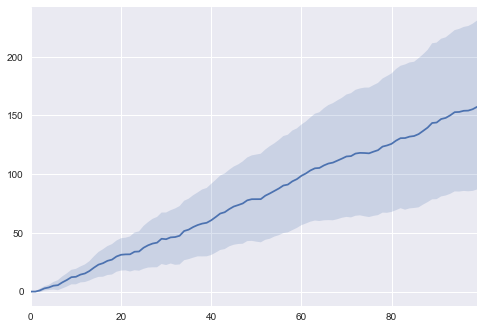

In [31]:
import seaborn as sns
sns.set(style="darkgrid")

# Plot the response with standard error
sns.tsplot(np.array(greedy_policy_data))

#### Softmax

Другая интерпретация $\varepsilon$-жадной стратегии
$$\pi_t(a)=\frac{\exp(\frac{1}{\varepsilon} \cdot Q_t(a))}{\sum_{b} \exp(\frac{1}{\varepsilon} \cdot Q_t(b))},\ \varepsilon > 0$$

**Задание**
1. Реализуйте данную стратегию
2. Что происходит, если $\varepsilon$ стремится к $0$? А бесконечности?
3. Сравните softmax и $\varepsilon$-жадную стратегии на модельной задаче.

In [34]:
class SoftmaxAgent(Agent):
    """ Implementation of Softmax Epsilon Policy agent"""
    def __init__(self, Model, epsilon):
        self.model = Model
        self.q_function = np.zeros((self.model.actions))
        self.argmax_actions_pool = np.random.uniform(size=(self.model.actions))
        self.epsilon = epsilon

    def choose_action(self):
        return int((1-self.epsilon) * np.random.randint(0, len(self.argmax_actions_pool)) +
                   self.epsilon * np.random.randint(0, self.model.actions))

#### Метод UCB (upper confidence bound)
Предложенный ниже алгоритм в некотором смысле является оптимальным, подробнее об этом [здесь]( http://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf). Для каждого момента $t$ он определяет множество наиболее потенциально выгодных действий. Выбор $a$ из $A_t$ происходит равновероятно.

$$\mathcal{A}_t = \arg\max Q_t(a) + \varepsilon \sqrt{\frac{2 \ln t}{c_t(a)}},\ \varepsilon \geq 0$$

Первая часть нам уже знакома, а вот вторую часть можно воспринимать, как величину, показывающую, насколько точна наша оценка $Q_t(a)$. Стратегия сама пытается найти баланс между *exploration/exploitation*.

**Задание**
1. Реализуйте данную стратегию
2. Что происходит, если $\varepsilon$ увеличивается?
3. На модельной задаче сравните лучшую версию $softmax$, $\varepsilon$-жадную стратегии и UCB метод.

#### Градиентный метод (gradient bandit policy)

Существуют еще так называемые адаптивные стратегии. Они могут быть использованы, если среда не является стационарной (распределение премий может меняться). В таком случае предлагается использовать уже знакомое нам экспоненциальное сглаживание.

Мы подсчитываем среднюю сглаженную премию к моменту $t$ по всем действиям ($\alpha$ регулирует глубину истории):
$$\bar{r}_{t+1} = (1-\alpha_t)\cdot\bar{r}_t(a)+\alpha_t r_{t+1} = \bar{r}_t +\alpha_t (r_{t+1}-\bar{r}_t(a)),\ \alpha_t \in [0, 1]$$

**Замечание**
Нужно все же сказать о сходимости подобных вещей, условие следующее:
* $\sum^{\infty} \alpha_t = \infty$
* $\sum^{\infty} \alpha^2_t < \infty$

Кстати, если взять  $\alpha_t = \frac{1}{t}$, то получится просто среднее значение всех $r$. Это подсказка на самое первое задание.

Для каждого действия у нас есть приоритет $p_t(a)$. После очередного шага идет корректировка с шагом $\lambda$. Если было выбрано действие $a$, то
$$p_{t+1}(a) = p_t(a)+\lambda(r_t-\bar{r}_t)(1-\pi_t(a))$$
в ином случае
$$p_{t+1}(a) = p_t(a)-\lambda(r_t-\bar{r}_t)\pi_t(a)$$

Тогда стратегия на момент $\pi_{t+1}$ будет выглядеть так:
$$\pi_{t+1}(a) = \frac{\exp(p_{t+1}(a))}{\sum_{b} \exp(p_{t+1}(b))}$$
Подробное обоснование метода вы можете найти в книге.


**Задание**
1. Реализуйте данную стратегию.
2. Покажите, какая из описанных моделей ведет себя лучше на модельной задаче.

### Дальнейшее чтение
Существует также задача многорукого бандита с контекстом (contextual bandits), формальная постановка выглядит следующим образом.
* $\mathcal{A}$ - множество допустимых действий
* $X$ - пространство контекстов среды
* $p(r|a, x)$ - распределение премии для действия $a$ в условиях контекста $x$
* $\pi_t(a|x)$ - стратегия агента на момент $t$ в условиях контекста $x$.

Пример использования такой модели при показе новостей [здесь](http://www.research.rutgers.edu/~lihong/pub/Li10Contextual.pdf).

## 2. Марковский процесс принятия решения (markov decison process)

### Постановка задачи

Пусть есть среда с конечным множество состояний $\mathcal{S}$. В момент времени $t$ агент, находясь в состоянии $s_t$, может выбрать произвольное действие $a_t \in \mathcal{A}_{s_t} \subset \mathcal{A}$. После чего среда переходит в состояние $s_{t+1}$ и агент получает награду $r_{t+1}$. Поведение среды задается распределением

$$p(s_{t+1}, r_{t+1}|s_t, a_t)  = \Pr\{ S_{t+1} = s_{t+1}, R_{t+1} =  r_{t+1} | S_t = s_t, A_t = a_t\}.$$

Агент обладает некоторой стратегией $\pi$, которая на шаге $t$ задает вероятности выбора действия $a_t \in \mathcal{A}_{s_t}$ для состояния $s_t$ $\pi_t(a_t|s_t) = p(a_t|s_t)$.

Неформально задача агента - максимизировать суммарную награду. Если процесс принятия решения конечный, то ее можно просто формализовать, как максимизацию величины
$$G = \sum_{t=0}^{T} R_{t+1},$$

где $T$ - момент времени, когда мы попали в какое-то конечное (терминальное) состояние, в данном контексте стоит воспринимать, как случайную величину. Если же процесс может длиться очень долго или бесконечно, то мы имем дело с диксконтированной  наградой
$$ G_t = \sum_{k=0}^{\infty} \gamma^{k} R_{t+k+1},$$
здесь $\gamma \in [0, 1]$ определяет на сколько далеко по времени мы смотрим в будущее.

**Замечания**

1. Если предположить, что попав в конечное состояние, то мы вегда остаемся в нем и в дальнейшем получаем только нулевую награду, то положив $\gamma = 1$, можно получить первый вариант определения.
2. "Марковость" процесса заключается в том, что среда изменяется и выдает награду только на основе текущего состояния и последнего действия агента.

**Задание**
1. Привидите жизненный пример марковского процесса принятия решения (это может быть какаю-нибудь игра и т.п.).
2. Можете ли вы привести пример игры, где принятие решения нельзя смоделировать с помощью марковского процесса?
3. Выведите следующие значения через $p(s_{t+1}, r_{t+1}|s_t, a_t)$, для простоты все распределения можно считать дискретными
  * $r(s_{t}, a_{t}) = \mathbb{E}[R_{t+1}|S_t = s_t, A_t = a_t]$ - средняя награда за действие $a_t$ в $s_t$ 
  * $p(s_{t+1} | s_t, a_t) = \Pr\{S_{t+1} = s_{t+1} | S_t = s_t, A_t = a_t \}$ - вероятность попасть в $s_{t+1}$ из $s_t$, сделав $a_t$.
  * $r(s_t, a_t, s_{t+1}) = \mathbb{E}[R_{t+1}|S_{t+1} = s_{t+1}, S_t = s_t, A_t = a_t]$ - средняя награда при переезде из $s_t$ в $s_{t+1}$, сделав $a_t$.

### Основные понятия

Ценность состояния (state-value function) при стратегии $\pi$, это награда, которую мы получим в дальнешем, стартуя из него

$$V^\pi(s) = \mathbb{E}[G_t|S_t=s] = \mathbb{E}\Big[\sum_{k=0}^{\infty} \gamma^{k+1}R_{t+k+1}|S_t=s\Big].$$

Ценности действия (action-value function) $a$ в состоянии $s$, это также дальнейшая награда, которую мы получим при стратегии $\pi$
$$Q^\pi(s, a) = \mathbb{E}[G_t|S_t=s, A_t=a] = \mathbb{E}\Big[\sum_{k=0}^{\infty} \gamma^{k+1}R_{t+k+1}|S_t=s,  A_t=a\Big].$$

Прим этом верны следующие тождества:

$$V^{\pi}(s) = \mathbb{E}\big[R_{t+1} + \gamma V^{\pi}(S_{t+1}) | S_t=s\big]$$

$$Q^{\pi}(s, a) = \mathbb{E}\big[R_{t+1} + \gamma Q^{\pi}(S_{t+1}, A_{t+1}) | S_t=s, A_t=a\big]$$

$$Q^{\pi}(s, a) = \mathbb{E}\big[R_{t+1} + \gamma V^{\pi}(S_{t+1}) | S_t=s, A_t=a\big]$$

Первы два являются уравнениямит Беллмана (Bellman equation).

**Замечание**
Важно отметить, в этих определениях стратегия $\pi$ фиксирована и не меняется со временем. Хотя очевидно, что на реальной практике это не так, потому что наша стратегия постоянно дообучается по мере изучения среды.

Мы будем считать стратегию $\pi^{*}$ оптимальной, если для любого состояния $s$ и любой другой стратегии $\pi$ верно $V_{\pi^{*}}(s) \geq V_{\pi}(s)$. Таких стратегий может быть несколько, однако функции $V(s)$ и $Q(s, a)$, которые они определяют, будут одинаковыми. Эти функции мы и обозначим, как оптимальные $V^*(s)$ и $Q^*(s, a)$.

Прим этом существует уравнение оптимальности Беллмана (Bellman optimality equation), подробнее [здесь](https://en.wikipedia.org/wiki/Bellman_equation):

$$V^*(s) = \max_{a \in \mathcal{A}} \mathbb{E}\big[R_{t+1} + \gamma V^*(S_{t+1}) | S_t=s, A_t=a\big]$$

$$Q^*(s, a) = \mathbb{E}\big[R_{t+1} + \gamma \max_{b \in \mathcal{A}} Q^*(S_{t+1}, b) | S_t=s, A_t=a\big]$$

Тогда следующие две жадные стратегии являются эквивалентными и оптимальными ($\mathcal{A}_t$ - множество):
$$\mathcal{A}_t = \arg\max_{a \in \mathcal{A}} \mathbb{E}\big[R_{t+1} + \gamma V^*(s_{t+1}) | s_t, a \big]$$
$$\mathcal{A}_t = \arg\max_{a \in \mathcal{A}} Q^*(s_t, a)$$

### Динамическое программирование (Dynamic programming)

Материал этой части строится на том, что $p(s',r|s,a)$ известна. Это пригодится нам для дальнейшего понимания.
#### Вычисление $V^{\pi}(s)$ (iterative policy evaluation)

Пусть есть некоторая фиксированная стратегия $\pi$, тогда для функции $V^{\pi}$ справедлива рекуррентная формула

$$V^{\pi}(s) = \sum_a \pi(a|s) \sum_{s',r} p(s',r|s,a) \big[r + \gamma V^{\pi}(s') \big]$$

Для простоты записи формул мы предполагаем, что распределение наград является дискретной случайной величиной. В ином случае необходимо использовать оператор интегрирования вместо суммы. Таким образом мы поможем вычислить функцию $V^{\pi}$ для каждого состояния $s$ используя итерационный алгоритм, инициализировав $V_0$ случайно

$$V_{n+1}(s) = \sum_a \pi(a|s) \sum_{s',r} p(s',r|s,a) \big[r + \gamma V_n(s') \big]$$

Кстати, если есть конечные состояния, то для них  $V(s)$ уже известно и эти значения стоит использовать при инициализации для более быстрой сходимости. Вычисления останавливаются, когда изменение функции $V(s)$ от итерации к итерации стало незначительным.

**Замечание**
1. Мы делаем предположение, что $p(s',r|s,a)$ нам известно, что на практике частно не так.
2. Вычисления $V_{n+1}$ можно делать *in place*, что только ускоряет сходимость, так как в процессе вычисления мы будем использовать, как значения из итерации $n$ так и какие-то новые значения из итерации $n+1$.

#### Улучшения стратегии $\pi$ (policy improvement theorem)
Пусть есть две стратегии $\pi$ и $\pi'$, при этом известно, что для любого состояния $s$ верно, что 
$$Q^{\pi}(s, \pi'(s)) \geq V^{\pi}(s),$$
то тогда справедливо неравенство
$$V^{\pi'}(s) \geq V^{\pi}(s).$$

Весь интерес данной теоремы заключается в том, что она позволяет нам улучшать текущую стратегию. Мы умеем вычислять $V^{\pi}(s)$, тогда 

$$
Q^{\pi}(s, a) =
\mathbb{E}\big[R_{t+1} + \gamma V^{\pi}(S_{t+1}) | S_t=s, A_t=a\big] =
\sum_{s',r}p(s',r|s, a)\big[ r + \gamma V^{\pi}(s') \big]
$$

Это позволяет нам улучшать стратегию

$$\pi'(s) = \arg\max_a Q^{\pi}(s, a).$$
Эта запись означает, что мы распределяем вероятность между множеством состояний, вычисленных в правой части. Если мы не можем улучить $V^{\pi'}$ относительно $V^{\pi}$, то значит функция ценности состояния оптимальна, так как удовлетвояют уравнению Беллмана, а значит оптимальна и стратегия.

#### Метод итерации стратегий (policy interation) 
Таким образом, совершая поочередно вычисление $V^{\pi}$ и улушчение $\pi$, найдем $\pi^*$. Обычный итеративный алгоритм с двумя этапами. Стоити отметить, что в качестве инициализции значений функции $V(s)$ можно использовать значения для предыдущей стратегии, это значительно ускоряет сходимость алгоритма.

#### Метод итерации ценности состояний (value interation) 
Также существует достаточно интересный подход для вычисления оптимальной $V^{*}(s)$, а значит и нахождения оптимальной стратегии.

$$V_{n+1}(s) = \max_a \sum_{s',r} p(s',r|s,a) \big[r + \gamma V_n(s') \big].$$

Относится к этому алгоритму можно по разному. Во-первых, его можно воспринимать, как то, что в методе итерации стратегий при вычисление $V^{\pi}$ мы не ждем сходимости, делаем одну итерацию, а затем сразу подправляем стратегию. С другой стороны по сути мы выписали уравнение оптимальности Беллмана и используем его в качестве итеративного алгоритма. К этому методу стоит относится именно, как к практическому.

**Задание**
1. Смоделируйте некоторую среду. Пусть будет 100 состояний. Распределение функции $p(s',r|s,a)$ можете взять на свое усмотрение.
2. Зафиксируйте некоторе значение дисконтирования. Найдите лучшую стратегию.
3. Сравните сходимость метода итерации стратегий и итерации ценности состояний.
4. Выберете наиболее быстрый метод. Посмотрите, как меняется значение функции $V^*(s)$ в зависимоти от $\gamma$.
5. Постройте график $\gamma \times V^*(s)$ для 5 произвольных состояний.

## 3. Модельная задача
В качестве модельной задачи выберем простые крестики-нолики. Существует два агента, один играет за $X$s, другой за $O$s. Один агент играет против другого и по сути являетя средой для другого игрока. Множество $\mathcal{S}_{X}$ - всевозможные допустимые расстановки крестиков после хода нолика и $\mathcal{S}_{O}$ - позиции после хода крестиков. Необходимо обучить обоих агентов в ходе серии игр друг с другом. Критерий достижения успеха - оба агента вам не проигрывают.

## 4. Метод временных разностей (Temporal difference)
Речь ниже пойдет уже о более современных методах, которые можно применять на практике. Представим, что мы вычисляем функцию $V^{\pi}(s)$ для нашей стратегии $\pi$. Пусть мы очередной раз посетили состояние $s_t$, а потом каким-то образом узнали итоговую наград $G_t$. Тогда постепенно посещая состояние $s_t$ раз за разом, используя экспоненциальное сглаживание, мы можем улучшать оценку $V^{\pi}$ для какой-то нашей стратегии $\pi$.

$$V^{\pi}(s_t) = V^{\pi}(s_t) + \alpha \big(G_t - V^{\pi}(s)\big)$$

Однако можно сделать небольшой трюк и расписать оценку $G_t$
$$V^{\pi}(s_t) = V^{\pi}(s_t) + \alpha \big(R_t + \gamma V^{\pi}(S_t) - V^{\pi}(s)\big),$$
тем самым мы получим формулы для итеративного вычисления функции $V^{\pi}(s)$ после каждого посещения состояния $s$. Аналогичным образомы мы можем вычислять и 
$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha \big(R_{t+1} + \gamma Q^{\pi}(S_{t+1}, A_{t+1}) - Q^{\pi}(s_t, a_t)\big).$$

#### SARSA (State-Action-Reward-State-Action)
Итак, мы хотим найти оптимальную стратегию $\pi^{*}$. Пусть у нас есть некоторая стартовая апроксимация $Q(s, a)$. На основе нее мы создаем $\varepsilon$ жадную стратегию $\mathcal{A}_s = \arg\max_{a \in \mathcal{A}} Q(s, a)$, тогда

$$\pi(a|s)=\frac{1-\varepsilon}{|\mathcal{A}_s|}[a \in \mathcal{A}_s] + \frac{\varepsilon}{|\mathcal{A}|},\ \varepsilon \in [0, 1].$$

После этого в соответствии со стратегией $\pi$ делаем шаг $a_t$ получаем награду $R_{t+1}$ и переходим в состояние $S_{t+1}$. Еще раз делаем выбор действия $A_{t+1} \sim \pi(a|S_{t+1})$, но не говорим его среде, а лишь используем для обновления $Q$
$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha \big(R_{t+1} + \gamma Q^{\pi}(S_{t+1}, A_{t+1}) - Q^{\pi}(s_t, a_t)\big).$$

При обновлении $Q$ так же есть средняя вариация, вы можете использовать среднее значение для оценки дальнейшего выигрыша

$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha \big(R_{t+1} + \gamma \sum_b \pi(b|S_{t+1}) Q^{\pi}(S_{t+1}, b) - Q^{\pi}(s_t, a_t)\big).$$

####  Q-обучение (Q-learning)
Идея этого подхода очень похожа, только жадность также применяется в момент обновления  функции $Q$ 
$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha \big(R_{t+1} + \gamma \max_{b} Q(S_{t+1}, b) - Q(s_t, a_t)\big).$$

**Задание**
1. Реализуйте оба алгоритма в рамках модельной задачи.
2. Оцените, какой из них быстрее сходится, как бы вы это стали делать?
3. Сравните на сколько сильно отличаются оценки $Q(s_t, a_t)$. Предложите свой способ.
4. Попробуйте сыграть со своим алгоритма. Используйте намеренно проигрышную стратегию за ноликов. Что произошло? Попробуйте обыграть агента за крестиков.